## 问题
!['a'](question.png)

In [1]:
# import necessary package
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn')
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# import data
PATH = '2005-2010.csv'
data = pd.read_csv(PATH)

### explore data

In [3]:
data.head()

,Unnamed: 0,sec_id,sec_name,tradedate,close,trade_status
0,0,000001.SZ,平安银行,2005-01-04,163.100,交易
1,1,000001.SZ,平安银行,2005-01-05,161.599,交易
2,2,000001.SZ,平安银行,2005-01-06,163.100,交易
3,3,000001.SZ,平安银行,2005-01-07,162.850,交易
4,4,000001.SZ,平安银行,2005-01-10,164.851,交易


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248717 entries, 0 to 2248716
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   sec_id        object 
 2   sec_name      object 
 3   tradedate     object 
 4   close         float64
 5   trade_status  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 102.9+ MB


### data clean

In [5]:
# 查看0值的数目
data.isna().sum()

Unnamed: 0      0
sec_id          0
sec_name        0
tradedate       0
close           0
trade_status    0
dtype: int64

In [6]:
# 移除不需要的column
data.drop(columns=['Unnamed: 0'], inplace=True)

## 转化tradedate的时间类型
data['tradedate'] = pd.to_datetime(data['tradedate'])

### 计算流程：计算对应（日期，股票）的60日收益率，并计算该日百分位为20%的值，并判断该只股票是不是当日的最有股，判断当日的最有股是不是连续5日都是最有股，计算该比例，得到最优股保持率。

In [7]:
# 为每个（工司，日期）对找到对应的前60天的收盘价
# 先把close列取出来
temp_data = data[['sec_name', 'tradedate', 'close']]
#temp_data = temp_data[:100000]

# 对每个日期加上60天的工作日时间
temp_data['tradedate'] = temp_data['tradedate'].apply(lambda x: x+pd.tseries.offsets.BDay(60))

# 通过pd.merge 合并
data = data.merge(temp_data, on=['tradedate', 'sec_name'], how='inner')

# for time, company_id in cur_data.index:
#     try:
#         cur_data.loc[time, company_id]['cur_rate'] = cur_data.loc[time-pd.DateOffset(days=30), company_id]['close']
#     except KeyError:
#         pass
    

# 修改columns名字
data.rename(columns={'close_x': 'today_close', 'close_y':'60_close'}, inplace=True)
#data

C:\Users\liu68\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [8]:
# 计算收益率
data['cur_rate'] = (data['today_close'] - data['60_close']) / data['60_close']
#data

In [9]:
# 计算每日前20%的收益率
percentile = data.groupby(['tradedate'])['cur_rate'].quantile(0.2)
data = data.merge(percentile, on=['tradedate'])
data.rename(columns={'cur_rate_x':'cur_rate', 'cur_rate_y':'percentile_rate'}, inplace=True)
#data

In [10]:
# 判断是不是最优股, 1代表是最优股，0代表不是最优股
data['most_value'] = data['cur_rate'] > data['percentile_rate'] 
data['most_value'] = data['most_value'].apply(lambda x: 1 if x is True else 0)
#data

In [11]:
# 统计每日最有股的数量
one_most_value = data.groupby(['tradedate'])['most_value'].sum()
# print('每日最优股分布\n',one_most_value.value_counts())

In [12]:
# 判断是不是连续五日都是最优股
temp = data[['sec_name', 'tradedate', 'most_value']]

for i in range(1, 5):
    cur_temp = data[['sec_name', 'tradedate', 'most_value']]
    cur_temp['tradedate'] = cur_temp['tradedate'].apply(lambda x: x+pd.tseries.offsets.BDay(i))
    
    temp = temp.merge(cur_temp, on=['tradedate', 'sec_name'], how='inner')
    temp['most_value'] = temp['most_value_x'] * temp['most_value_y']
    temp.drop(columns=['most_value_x', 'most_value_y'], inplace=True)


five_most_value = temp.groupby(['tradedate'])['most_value'].sum()
# print('最优保持率分布\n',five_most_value.value_counts())

result =  five_most_value / one_most_value

C:\Users\liu68\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, '日期')

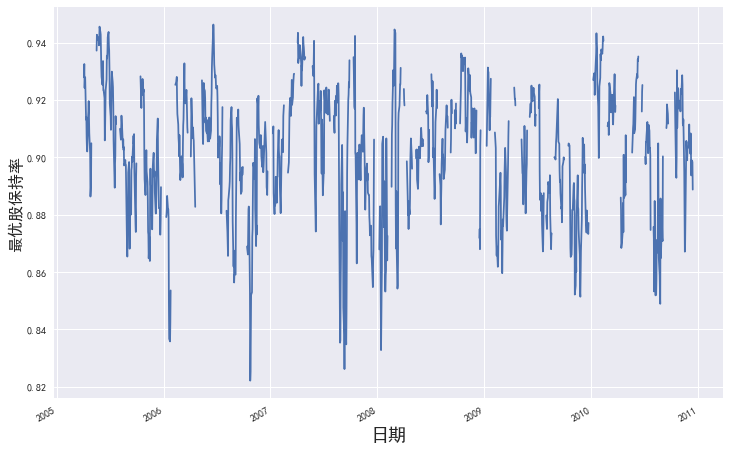

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
result.plot(ax=ax)
ax.set_ylabel('最优股保持率', fontsize=16)
ax.set_xlabel('日期', fontsize=18)